In [1]:
from transformers import BartForConditionalGeneration, AutoTokenizer, AutoModel, utils
from nltk.metrics.distance import edit_distance
from string import Template
import numpy as np
import math
from itertools import combinations
import torch
import os
from typing import List, Tuple
import warnings
import re
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

from muss.feature_extraction import (get_lexical_complexity_score, get_levenshtein_similarity,
                                       get_dependency_tree_depth)

from utils import *

In [2]:
GPU = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = GPU

if torch.cuda.is_available():    
    print(torch.cuda.current_device())
    print(torch.cuda.device)
    torch.cuda.device = GPU
    print(torch.cuda.device)
    device = 'cuda'
else:
    device = 'cpu'
print(f'device: {device}')

0
<class 'torch.cuda.device'>
1
device: cuda


In [3]:
# Initialize tokenizer and model. Be sure to set output_attentions=True.
# Load BART fine-tuned for summarization on CNN/Daily Mail dataset
model_path = "/srv/scratch6/kew/ats/muss/resources/models/muss_en_mined_hf"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = BartForConditionalGeneration.from_pretrained(model_path, output_attentions=True)
model = model.eval()
model = model.to(device)

In [16]:
src_sentence = "This is extremely hard to comprehend."

def run_inference(src_text, batch_size=32, step_size=0.25, verbose=False):
    
    inputs = []
    outputs = []
    
    # possible combinations = num_trials^4
    for a in np.arange(0.0, 1.5, step_size):
        a = round(a, 2) # target values = 0.0, 0.05, 0.1, 0.15, ...
        for b in np.arange(0.0, 1.5, step_size):
            b = round(b, 2) # target values = 0.0, 0.05, 0.1, 0.15, ...
            for c in np.arange(0.0, 1.5, step_size):
                c = round(c, 2) # target values = 0.0, 0.05, 0.1, 0.15, ...
                for d in np.arange(0.0, 1.5, step_size):
                    d = round(d, 2) # target values = 0.0, 0.05, 0.1, 0.15, ...
                    
                    params = {
                        'len_ratio': a,
                        'lev_sim': b,
                        'word_rank': c,
                        'tree_depth': d,
                    }
                    
                    inputs.append(construct_input(src_text, params))

    if verbose:
        print(f'Number of possible inputs: {len(inputs)}')

    
    for batch_inputs in tqdm(batch(inputs, batch_size), total=len(inputs)/batch_size):
        batch_predictions = generate(batch_inputs)
        # print(batch_inputs[:3])
        
        for src, pred in zip(batch_inputs, batch_predictions):
            
            src_text = strip_params(src)
            pred = pred.strip()
            
            data = {
                'src': src_text,
                'pred': pred,
                'attr': {
                    'len_ratio': len(pred) / len(src_text),
                    'lev_sim': get_levenshtein_similarity(src_text, pred),
                    'word_rank': get_lexical_complexity_score(pred) / get_lexical_complexity_score(src_text),
                    'tree_depth': get_dependency_tree_depth(pred) / get_dependency_tree_depth(src_text),
                },
                'params': parse_params(src),
            }
            outputs.append(data)
        
    return outputs
    

In [27]:
data = []

inputs = [
    'This is extremely hard to comprehend.',
    'The mouse was eaten by the cat.',
    'Saint Petersburg, formerly known as Petrograd and later Leningrad, is the second-largest city in Russia.',
    'Effective altruism advocates using evidence to determine the most effective ways to benefit others.',
    'Memorial West\'s class is one of several programs offered through hospitals to help children stay healthy through exercise and proper eating.',
    'The idea is to encourage healthy eating and exercise as early as possible to prevent health problems later on.',
]
for src_text in inputs:
    data += run_inference(src_text, verbose=True)


Number of possible inputs: 1296


41it [01:29,  2.19s/it]                          


Number of possible inputs: 1296


41it [01:38,  2.40s/it]                          


Number of possible inputs: 1296


41it [02:14,  3.29s/it]                          


Number of possible inputs: 1296


41it [02:04,  3.03s/it]                          


Number of possible inputs: 1296


41it [02:15,  3.30s/it]                          


Number of possible inputs: 1296


41it [02:13,  3.26s/it]                          


In [28]:
len(data)

7776

In [29]:
# df = pd.DataFrame(data, orient=)
df = pd.json_normalize(data)

In [31]:
with open('../results/access_params_and_attrs.json', 'w') as f:
    json.dump(data, f)

In [32]:
df

,src,pred,attr.len_ratio,attr.lev_sim,attr.word_rank,attr.tree_depth,params.len_ratio,params.lev_sim,params.word_rank,params.tree_depth
0,This is extremely hard to comprehend.,This is very hard to comprehend extremely.,1.135135,0.784810,1.000000,0.666667,0.00,0.00,0.00,0.00
1,This is extremely hard to comprehend.,This is very hard to comprehend extremely.,1.135135,0.784810,1.000000,0.666667,0.00,0.00,0.00,0.25
2,This is extremely hard to comprehend.,This is very hard to comprehend extremely.,1.135135,0.784810,1.000000,0.666667,0.00,0.00,0.00,0.50
3,This is extremely hard to comprehend.,This is very hard to comprehend extremely.,1.135135,0.784810,1.000000,0.666667,0.00,0.00,0.00,0.75
4,This is extremely hard to comprehend.,This is very hard to comprehend extremely.,1.135135,0.784810,1.000000,0.666667,0.00,0.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...
7771,The idea is to encourage healthy eating and ex...,"The idea is that as early as possible, people ...",0.818182,0.560000,1.032470,0.666667,1.25,1.25,1.25,0.25
7772,The idea is to encourage healthy eating and ex...,"The idea is that as early as possible, people ...",0.818182,0.560000,1.032470,0.666667,1.25,1.25,1.25,0.50
7773,The idea is to encourage healthy eating and ex...,"The idea is that as early as possible, people ...",0.818182,0.560000,1.032470,0.666667,1.25,1.25,1.25,0.75
7774,The idea is to encourage healthy eating and ex...,"The idea is that as early as possible, people ...",0.818182,0.560000,1.032470,0.666667,1.25,1.25,1.25,1.00


<AxesSubplot:>

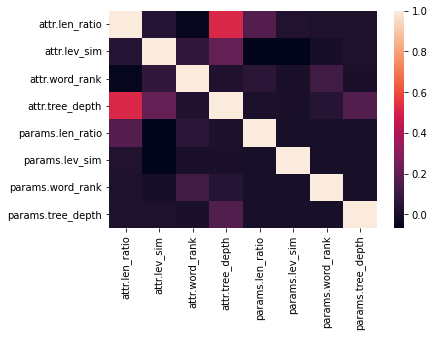

In [33]:
# print(df[['attr.len_ratio', 'params.len_ratio']].corr())
# print()
# print(df[['attr.lev_sim', 'params.lev_sim']].corr())
# print()
# print(df[['attr.word_rank', 'params.word_rank']].corr())
# print()
# print(df[['attr.tree_depth', 'params.tree_depth']].corr())
corr = df.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)